# Convolutional LSTM for action prediction

- keep track of best validation value + Save checkpoints with information (autosave)
- clean naming (of how models are saved, configs are saved, runs are called)
- confusion matrix of result / comparison with baseline LSTM (that only takes in actions)
- wandb/ tensorboard integration (also for gradient information?)
- hydra integration for hyperparameters?

### Imports

In [1]:
import pickle
import hydra
import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torchinfo import summary

from tqdm.auto import tqdm

from omegaconf import OmegaConf

from matplotlib import pyplot as plt

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


### Hyperparameters

In [2]:
# input size is 960 or 1
train_imgs = True
save_infos = False

# preprocessing
seq_length = 20
training_set_size = 0.80

# lstm configuration
hidden_size = 200
num_layers = 1
num_classes = 4
save_model = False

# training
num_epochs = 2000
learning_rate = 0.01
optimizer_type = "Adam"

In [3]:
if train_imgs:
    input_size = 960
else:
    input_size = 1

if num_classes == 1:
    hot_encoding = False
elif num_classes == 4:
    hot_encoding = True

In [ ]:
# hydra integration for hyperparameters
hydra.core.global_hydra.GlobalHydra.instance().clear()

hydra.initialize(
    version_base=None, config_path="conf"
)  # Assume the configuration file is in the current folder
cfg = hydra.compose(config_name="config")
# Can be used in the following way: cfg.params.learning_rate
print(OmegaConf.to_yaml(cfg))

### Load datasets

In [4]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

### Preprocess data

In [7]:
hot_encoding = True

# preprocess with sequence length
x_acts, x_imgs, y_acts = preprocess.sliding_windows(
    oracle_data, seq_length, hot_encoding
)
# data, train, test split
data, train, test = preprocess.split(x_acts, x_imgs, y_acts, training_set_size)
dataX_acts, dataX_imgs, dataY_acts = data
trainX_acts, trainX_imgs, trainY_acts = train
testX_acts, testX_imgs, testY_acts = test

### Initialize models

In [8]:
#from torchsummary import summary
f
input_size = 960

cnn = nets.CNN(seq_length)
lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

if train_imgs:
    features = cnn(trainX_imgs[0:32])
else:
    features = trainX_acts

outputs = lstm(features)

print("CNN input shape:", trainX_imgs[0:32].size())
print("CNN output shape:", features.size())

print("LSTM input shape:", features.size())
print("LSTM output shape:", outputs.size())

print("Label shape:", trainY_acts[0:32].size())

print("SUMMARY CNN \n", summary(cnn, trainX_imgs[0:32].size()), "\n")
print('SUMMARY LSTM \n', summary(lstm, (32, 20, 960)))


CNN input shape: torch.Size([32, 20, 3, 32, 32])
CNN output shape: torch.Size([32, 20, 960])
LSTM input shape: torch.Size([32, 20, 960])
LSTM output shape: torch.Size([32, 4])
Label shape: torch.Size([32, 4])
SUMMARY CNN 
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 20, 960]             --
├─Conv2d: 1-1                            [640, 20, 28, 28]         1,520
├─Conv2d: 1-2                            [640, 40, 24, 24]         20,040
├─MaxPool2d: 1-3                         [640, 40, 12, 12]         --
├─Conv2d: 1-4                            [640, 60, 8, 8]           60,060
├─MaxPool2d: 1-5                         [640, 60, 4, 4]           --
Total params: 81,620
Trainable params: 81,620
Non-trainable params: 0
Total mult-adds (G): 10.61
Input size (MB): 7.86
Forward/backward pass size (MB): 217.91
Params size (MB): 0.33
Estimated Total Size (MB): 226.10

SUMMARY LSTM 
Layer (type:depth-idx)                   

### Tensorboard integrations

In [ ]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
%tensorboard --logdir=runs

### Network training

In [9]:
def recode_values(outputs):

    # max threshold, absolut
    adopted_output = [
        abs(output.detach().cpu().numpy()[0])
        * (output.detach().cpu().numpy() >= max(output.detach().cpu().numpy()))
        for output in outputs
    ]
    # all values 0 or 1, make it a tensor again to make np.where work
    adopted_output = torch.FloatTensor(
        [list(np.where(variable > 0, 1, 0)) for variable in adopted_output]
    )
    # reverse the original coding to get a single int again
    adopted_output = [np.where(data == 1)[0][0] for data in adopted_output]  #

    return adopted_output

In [10]:
def compute_correct(new_data_predict, dataY_plot):
    new_dataY_plot = [np.where(r == 1)[0][0] for r in dataY_plot]
    counter = 0
    for i in range(len(new_data_predict)):
        if new_data_predict[i] == new_dataY_plot[i]:
            counter += 1
    return counter

def compute_acc(outputs, labels):
    outputs = recode_values(outputs)
    correct = compute_correct(outputs, labels)
    acc = correct / len(outputs)

    return acc

In [11]:
train_imgs = True

if train_imgs:
    params = list(cnn.parameters()) + list(lstm.parameters())
else:
    params = lstm.parameters()

# MSELoss - regression, CrossEntropyLoss for labels or BCEWithLogitsLoss
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.1

if optimizer_type == "Adam":
    optimizer = torch.optim.Adam(params, lr=learning_rate)
elif optimizer_type == "SGD":
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)

num_epochs = 100
#train_imgs = True

# save current conf infos
if save_infos:
    local_time = str(datetime.datetime.now().isoformat())
    name = local_time + "_configs"
    OmegaConf.save(cfg, "runs/" + name)

In [12]:
def plot_losses(train_loss, test_loss, num_epochs):

    font = 24
    hfont = {"fontname": "Helvetica"}

    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams["axes.titlepad"] = 13
    plt.rcParams["xtick.major.pad"] = "8"  # axis distance
    plt.rcParams["ytick.major.pad"] = "8"

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    with plt.style.context("seaborn-darkgrid"):

        plt.rcParams.update({"font.size": font})
        plt.plot(test_loss, color="red", linewidth=2, label="Validation Loss")
        plt.plot(train_loss, color="slategray", linewidth=2, label="Training Loss")
        plt.legend(fontsize=font)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss")

        # plt.savefig('difficult_env_loss_epochs.pdf', bbox_inches="tight")
        plt.show()


def plot_acc(train_dis, test_dis, num_epochs):

    font = 24
    hfont = {"fontname": "Helvetica"}

    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams["axes.titlepad"] = 13
    plt.rcParams["xtick.major.pad"] = "8"  # axis distance
    plt.rcParams["ytick.major.pad"] = "8"

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.rcParams.update({"font.size": font})

    with plt.style.context("seaborn-darkgrid"):
        plt.plot(train_dis, label="Training", linewidth=3, color="tab:blue")
        plt.plot(test_dis, c="indianred", label="Validation", linewidth=3)
        #plt.title("Difficult Environment", fontsize=font)
        plt.legend(fontsize=font)
        plt.xlabel("Epochs", fontsize=font, **hfont)
        plt.ylabel("Accuracy", fontsize=font, **hfont)

        plt.xlim(xmax=num_epochs + 5, xmin=-5)

        # plt.savefig('difficult_env_euclidean_distance_epochs.pdf', bbox_inches="tight")

        plt.show()

In [75]:
import numpy as np

def split(x_acts, x_imgs, y_acts, training_set_size):

    train_size = int(len(x_acts) * training_set_size)
    test_size = len(x_acts) - train_size
    
    idx_shuf = list(range(len(x_acts)))
    random.shuffle(idx_shuf)

    x_acts = [x_acts[i] for i in idx_shuf]
    y_acts = [y_acts[i] for i in idx_shuf]
    
    x_imgs_shuffled = []
    for i in idx_shuf:
        x_imgs_shuffled.append(x_imgs[i])
        
    x_imgs = torch.stack(x_imgs_shuffled)
    
    x_acts = np.asarray(x_acts)
    y_acts = np.asarray(y_acts)
    
    print('types', type(x_acts), type(x_imgs), type(y_acts))
    
    # (full) data set
    dataX_acts = Variable(torch.Tensor(np.array(x_acts)))
    dataX_imgs = Variable(torch.Tensor(x_imgs))
    dataY_acts = Variable(torch.Tensor(np.array(y_acts)))

    # training set
    trainX_acts = Variable(torch.Tensor(np.array(x_acts[0:train_size])))
    trainX_imgs = Variable(torch.Tensor(np.array(x_imgs[0:train_size])))
    trainY_acts = Variable(torch.Tensor(np.array(y_acts[0:train_size])))

    # validation set
    testX_acts = Variable(torch.Tensor(np.array(x_acts[train_size : len(x_acts)])))
    testX_imgs = Variable(torch.Tensor(np.array(x_imgs[train_size : len(x_imgs)])))
    testY_acts = Variable(torch.Tensor(np.array(y_acts[train_size : len(y_acts)])))

    return (
        [dataX_acts, dataX_imgs, dataY_acts],
        [trainX_acts, trainX_imgs, trainY_acts],
        [testX_acts, testX_imgs, testY_acts],
    )

In [76]:
# training loop

def training_loop(trainX_imgs, trainY_acts, testX_imgs, testY_acts, seq_length):
    
    num_epochs = 200

    with tqdm(total=num_epochs, unit=" Episode", desc="Progress") as pbar:

        seq_length = 20
        learning_rate = 0.0001 # 0.0001 ?
        hidden_size = 200

        cnn = nets.CNN(seq_length)
        lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
        criterion = torch.nn.CrossEntropyLoss()

        params = list(cnn.parameters()) + list(lstm.parameters())
        optimizer = torch.optim.Adam(params, lr=learning_rate)

        # tracking results
        train_loss_lst, test_loss_lst = [], []
        train_acc_lst, test_acc_lst = [], []
        writer = SummaryWriter()

        for epoch in range(num_epochs):

            loss_test_col = 0
            acc_test_col = 0
            for i in range(7):
                start = 32*i
                end = 32*(i+1)
                # compute validation set performance
                with torch.no_grad():
                    # choose training style
                    if train_imgs:
                        features = cnn(testX_imgs[start:end])
                    else:
                        features = testX_acts
                    outputs = lstm(features)

                    # loss
                    loss_test = criterion(outputs, testY_acts[start:end])
                    loss_test_col += loss_test.item()

                    # compute train acc
                    acc_test = compute_acc(outputs, testY_acts[start:end])
                    acc_test_col += acc_test

                #print(acc_test)

            loss_train_col = 0
            acc_train_col = 0
            for i in range(27):
                # choose training style
                if train_imgs:
                    features = cnn(trainX_imgs[32*i:32*(i+1)])  # forwarad pass of the cnn
                else:
                    features = trainX_acts

                # forwarad pass of the lstm
                outputs = lstm(features)
                optimizer.zero_grad()  # zero the parameter gradients

                # loss + optimize
                loss_train = criterion(outputs, trainY_acts[32*i:32*(i+1)])
                loss_train.backward()
                optimizer.step()

                loss_train_col += loss_train.item()

                # compute train acc
                acc_train = compute_acc(outputs, trainY_acts[32*i:32*(i+1)])
                acc_train_col += acc_train

            # display
            if epoch % (num_epochs / 10) == 0:
                epoch = (4 - len(str(epoch))) * str(0) + str(epoch)
                print(
                    "Epoch: %s - Train Loss: %1.3f, Train Acc: %1.3g - Test Loss: %1.3f, Test Acc: %1.3g"
                    % (epoch, loss_train_col/27, acc_train_col/27, loss_test_col/7, acc_test_col/7)
                )
            #print(features)

            # collect tensorboard logs

            # collect plotting logs
            train_loss_lst.append(loss_train_col/27)
            test_loss_lst.append(loss_test_col/7)
            train_acc_lst.append(acc_train_col/27)
            test_acc_lst.append(acc_test_col/7)

            pbar.update(1)

        writer.close()
        plot_losses(train_loss_lst, test_loss_lst, num_epochs)
        plot_acc(train_acc_lst, test_acc_lst, num_epochs)
        
        print("Finished Training")
        
        return train_acc_lst, test_acc_lst


sequence lenth 20 easy environment
types <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


Progress:   0%|          | 0/200 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 1.344, Train Acc: 0.319 - Test Loss: 1.395, Test Acc: 0.0848
Epoch: 0020 - Train Loss: 1.015, Train Acc: 0.568 - Test Loss: 1.041, Test Acc: 0.603
Epoch: 0040 - Train Loss: 0.329, Train Acc: 0.873 - Test Loss: 0.386, Test Acc: 0.848
Epoch: 0060 - Train Loss: 0.168, Train Acc: 0.944 - Test Loss: 0.296, Test Acc: 0.879
Epoch: 0080 - Train Loss: 0.124, Train Acc: 0.959 - Test Loss: 0.231, Test Acc: 0.893
Epoch: 0100 - Train Loss: 0.094, Train Acc: 0.965 - Test Loss: 0.244, Test Acc: 0.911
Epoch: 0120 - Train Loss: 0.056, Train Acc: 0.983 - Test Loss: 0.234, Test Acc: 0.929
Epoch: 0140 - Train Loss: 0.030, Train Acc: 0.993 - Test Loss: 0.252, Test Acc: 0.915
Epoch: 0160 - Train Loss: 0.122, Train Acc: 0.962 - Test Loss: 0.339, Test Acc: 0.902
Epoch: 0180 - Train Loss: 0.013, Train Acc: 0.998 - Test Loss: 0.240, Test Acc: 0.924


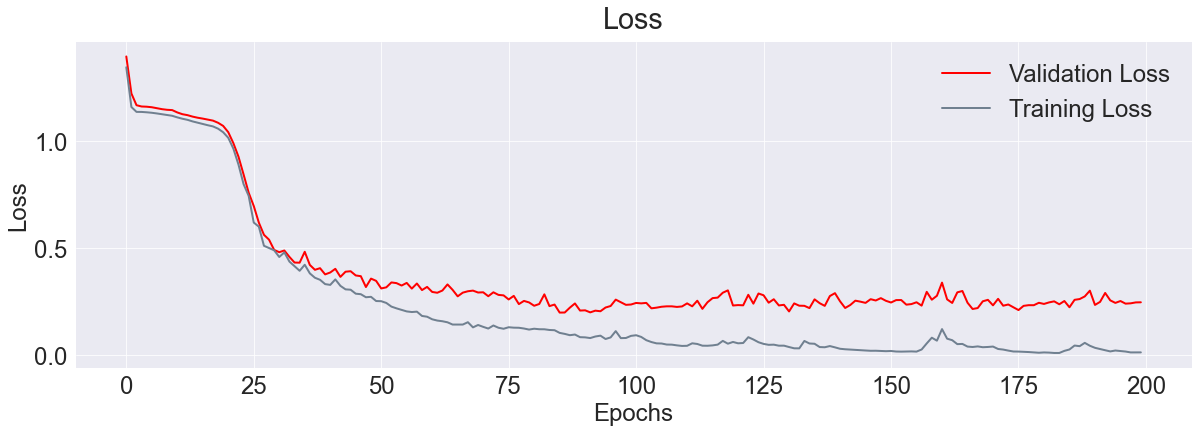

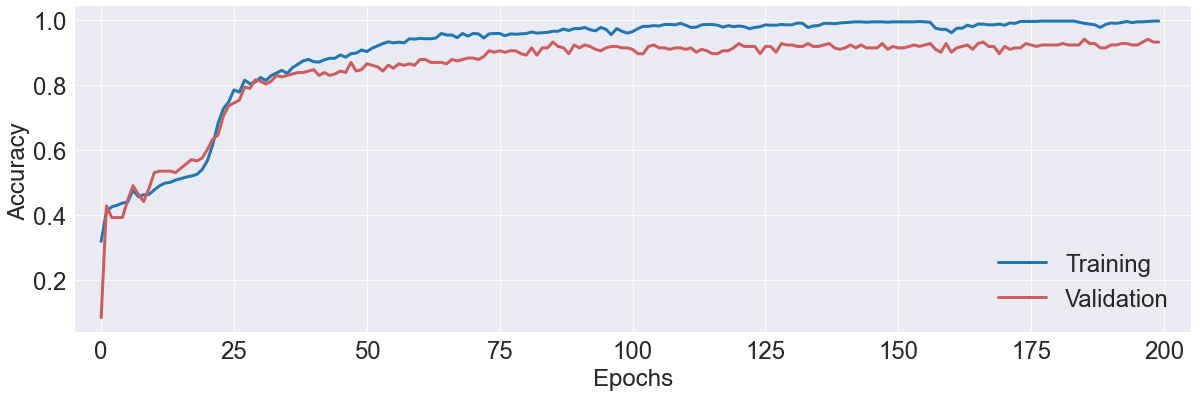

Finished Training

sequence lenth 20 medium environment
types <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


Progress:   0%|          | 0/200 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 1.387, Train Acc: 0.264 - Test Loss: 1.386, Test Acc: 0.259
Epoch: 0020 - Train Loss: 1.381, Train Acc: 0.281 - Test Loss: 1.384, Test Acc: 0.299
Epoch: 0040 - Train Loss: 1.271, Train Acc: 0.414 - Test Loss: 1.361, Test Acc: 0.366
Epoch: 0060 - Train Loss: 1.150, Train Acc: 0.488 - Test Loss: 1.402, Test Acc: 0.33
Epoch: 0080 - Train Loss: 0.991, Train Acc: 0.562 - Test Loss: 1.519, Test Acc: 0.348
Epoch: 0100 - Train Loss: 0.893, Train Acc: 0.601 - Test Loss: 1.717, Test Acc: 0.281
Epoch: 0120 - Train Loss: 0.687, Train Acc: 0.72 - Test Loss: 1.990, Test Acc: 0.268
Epoch: 0140 - Train Loss: 0.580, Train Acc: 0.764 - Test Loss: 2.290, Test Acc: 0.29
Epoch: 0160 - Train Loss: 0.446, Train Acc: 0.837 - Test Loss: 2.619, Test Acc: 0.286
Epoch: 0180 - Train Loss: 0.312, Train Acc: 0.891 - Test Loss: 3.024, Test Acc: 0.263


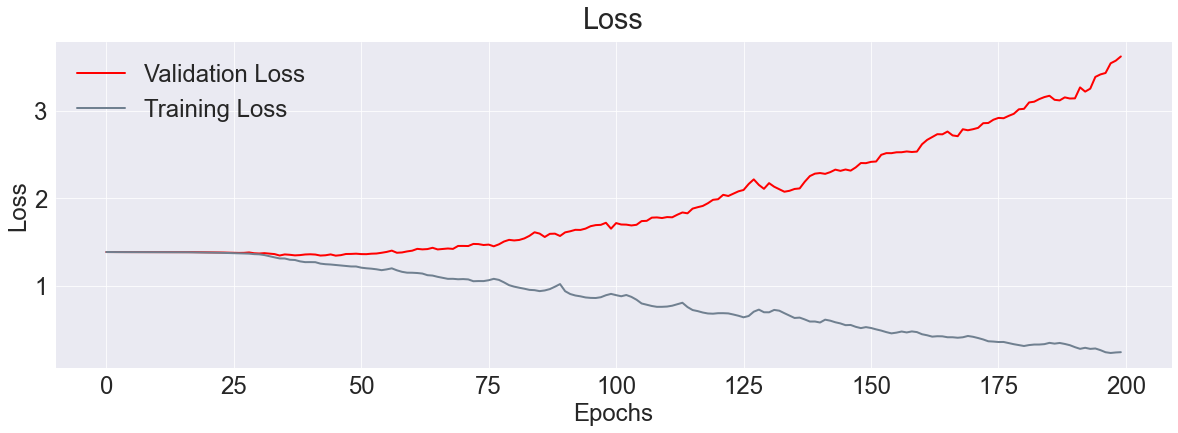

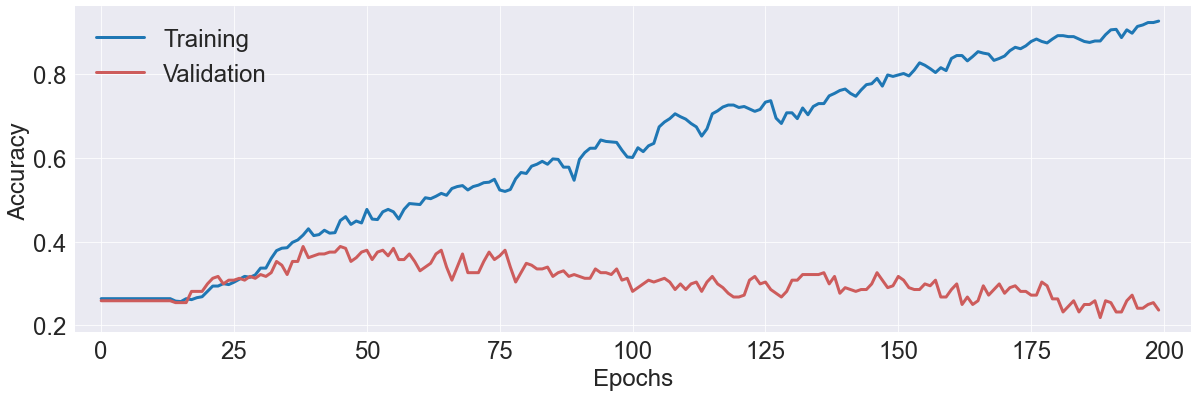

Finished Training

sequence lenth 20 difficult environment
types <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


Progress:   0%|          | 0/200 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 1.386, Train Acc: 0.259 - Test Loss: 1.388, Test Acc: 0.281
Epoch: 0020 - Train Loss: 1.385, Train Acc: 0.256 - Test Loss: 1.385, Test Acc: 0.246
Epoch: 0040 - Train Loss: 1.381, Train Acc: 0.284 - Test Loss: 1.382, Test Acc: 0.281
Epoch: 0060 - Train Loss: 1.357, Train Acc: 0.315 - Test Loss: 1.387, Test Acc: 0.29
Epoch: 0080 - Train Loss: 1.311, Train Acc: 0.353 - Test Loss: 1.455, Test Acc: 0.29
Epoch: 0100 - Train Loss: 1.197, Train Acc: 0.443 - Test Loss: 1.480, Test Acc: 0.281
Epoch: 0120 - Train Loss: 1.079, Train Acc: 0.524 - Test Loss: 1.642, Test Acc: 0.246
Epoch: 0140 - Train Loss: 0.941, Train Acc: 0.608 - Test Loss: 1.744, Test Acc: 0.295
Epoch: 0160 - Train Loss: 0.788, Train Acc: 0.678 - Test Loss: 2.018, Test Acc: 0.254
Epoch: 0180 - Train Loss: 0.642, Train Acc: 0.726 - Test Loss: 2.444, Test Acc: 0.272


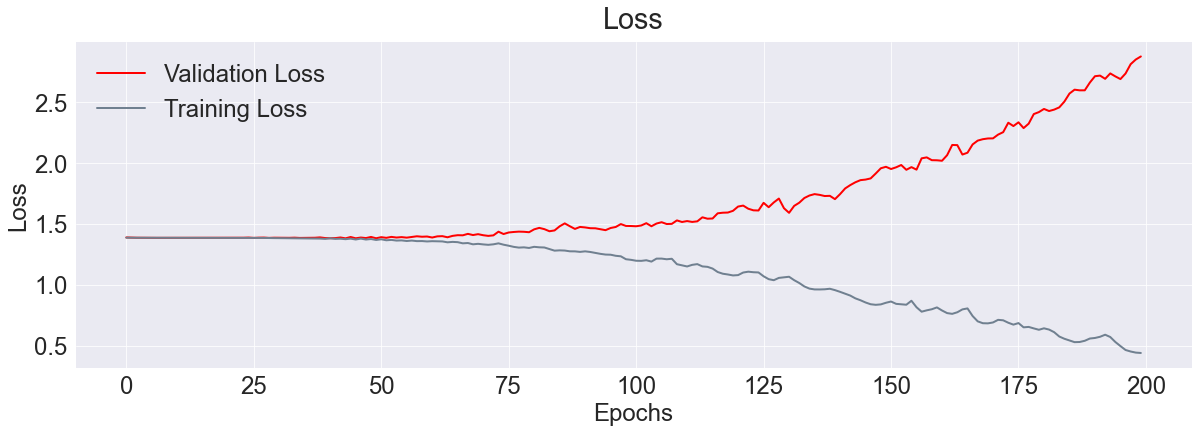

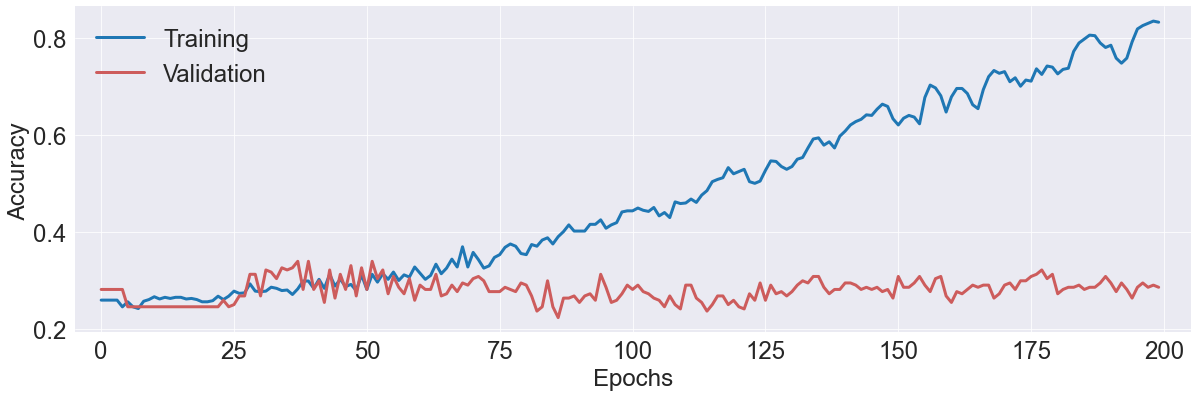

Finished Training


In [77]:
environments = [
    'oracle_reversed_data',
    'oracle_reversed_random_data_small',
    'tmaze_random_reverse_data',
]

def run_all_environments(environments):

    train_acc_col = []
    test_acc_col = []

    for idx, data in enumerate(environments):
        
        for i in range(1):
            
            i = 20
            
            if data == 'oracle_reversed_data':
                with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
                    data_set = pickle.load(handle)
            if data == 'oracle_reversed_random_data_small':
                with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
                    data_set = pickle.load(handle)
            if data == 'tmaze_random_reverse_data':
                with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
                    data_set = pickle.load(handle)
            
            print("")
            if idx == 0:
                print("sequence lenth", i, "easy environment")
            if idx == 1:
                print("sequence lenth", i, "medium environment")
            if idx == 2:
                print("sequence lenth", i, "difficult environment")
            seq_length = i
            shuffle = True
        
        
            x_acts, x_imgs, y_acts = preprocess.sliding_windows(data_set, seq_length, hot_encoding)
            # data, train, test split
            data, train, test = split(x_acts, x_imgs, y_acts, training_set_size)
            dataX_acts, dataX_imgs, dataY_acts = data
            trainX_acts, trainX_imgs, trainY_acts = train
            testX_acts, testX_imgs, testY_acts = test
            
            train_acc, test_acc = training_loop(trainX_imgs, trainY_acts, testX_imgs, testY_acts, seq_length)
            
            train_acc_col.append(train_acc)
            test_acc_col.append(test_acc)
            
    return train_acc_col, test_acc_col

train_acc, test_acc = run_all_environments(environments)

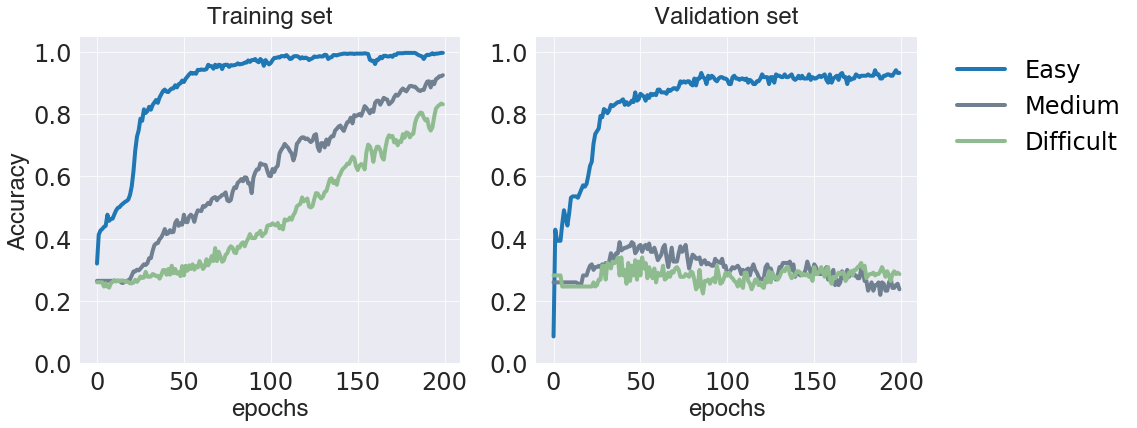

In [88]:
font = 24
hfont = {"fontname": "Helvetica"}

# plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Training set", fontsize=font)
    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("Epochs", fontsize=font, **hfont)
    
    # easy
    plt.subplot(1, 2, 1)
    (y1,) = plt.plot(
        train_acc[0],
        linestyle="solid",
        c="tab:blue",
        label="Easy",
        linewidth=4.0,
    )
    (y2,) = plt.plot(
        train_acc[1],
        c="slategray",
        linestyle="solid",
        label="Medium",
        linewidth=4.0,
    )
    (y3,) = plt.plot(
        train_acc[2],
        c="darkseagreen",
        linestyle="solid",
        label="Difficult",
        linewidth=4.0,
    )
    
    plt.ylim(ymax=1.05, ymin=0)
    plt.yticks(np.arange(0, 1.05, 0.2))
    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Training set", fontsize=font, **hfont)

    plt.subplot(1, 2, 2)
    plt.plot(
        test_acc[0],
        linestyle="solid",
        c="tab:blue",
        label="Easy",
        linewidth=4.0,
    )
    plt.plot(
        test_acc[1],
        c="slategray",
        linestyle="solid",
        label="Medium",
        linewidth=4.0,
    )
    plt.plot(
        test_acc[2],
        c="darkseagreen",
        linestyle="solid",
        label="Difficult",
        linewidth=4.0,
    )

    plt.ylim(ymax=1.05, ymin=0)
    plt.yticks(np.arange(0, 1.05, 0.2))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Validation set", fontsize=font, **hfont)

plt.legend(
    handles=[y1, y2, y3],
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
)
plt.savefig("ConvLSTM_action_results.pdf", bbox_inches="tight")

In [ ]:
print(train_acc)
print(test_acc)

In [ ]:
with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    data_set = pickle.load(handle)
    
with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    data_set = pickle.load(handle)
    
seq_length = 20

x_acts, x_imgs, y_acts = preprocess.sliding_windows(data_set, seq_length, hot_encoding)
# data, train, test split
data, train, test = preprocess.split(x_acts, x_imgs, y_acts, training_set_size)
dataX_acts, dataX_imgs, dataY_acts = data
trainX_acts, trainX_imgs, trainY_acts = train
testX_acts, testX_imgs, testY_acts = test

In [ ]:
num_epochs = 20

import random

with tqdm(total=num_epochs, unit=" Episode", desc="Progress") as pbar:

    seq_length = 20
    learning_rate = 0.01 # 0.0001 ?
    hidden_size = 200

    cnn = nets.CNN(seq_length)
    lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
    criterion = torch.nn.CrossEntropyLoss()

    params = list(cnn.parameters()) + list(lstm.parameters())
    #optimizer = torch.optim.Adam(params, lr=learning_rate)
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)

    # tracking results
    train_loss_lst, test_loss_lst = [], []
    train_acc_lst, test_acc_lst = [], []
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        
        train_imgs = True

        loss_test_col = 0
        acc_test_col = 0
        for i in range(7):
            # compute validation set performance
            
            #val = random.randrange(1, len(testX_imgs)-32)
            
            with torch.no_grad():
                # choose training style
                if train_imgs:
                    features = cnn(testX_imgs[32*i:32*(i+1)])
                else:
                    features = testX_acts
                outputs = lstm(features)

                # loss
                loss_test = criterion(outputs, testY_acts[32*i:32*(i+1)])
                loss_test_col += loss_test.item()

                # compute train acc
                acc_test = compute_acc(outputs, testY_acts[32*i:32*(i+1)])
                #print(acc_test)
                acc_test_col += acc_test

             #print(acc_test)

        loss_train_col = 0
        acc_train_col = 0
        for i in range(50):
            # choose training style
            if train_imgs:
                features = cnn(trainX_imgs[i:32+i])  # forwarad pass of the cnn
            else:
                features = trainX_acts
                
            val = random.randrange(1, len(trainX_imgs)-32)

            # forwarad pass of the lstm
            outputs = lstm(features)
            optimizer.zero_grad()  # zero the parameter gradients

            # loss + optimize
            loss_train = criterion(outputs, trainY_acts[val:32+val])
            loss_train.backward()
            optimizer.step()

            loss_train_col += loss_train.item()

            # compute train acc
            acc_train = compute_acc(outputs, trainY_acts[val:32+val])
            acc_train_col += acc_train

        # display
        if epoch % 1 == 0: #(num_epochs / 10)
            epoch = (4 - len(str(epoch))) * str(0) + str(epoch)
            print(
                "Epoch: %s - Train Loss: %1.3f, Train Acc: %1.3g - Test Loss: %1.3f, Test Acc: %1.3g"
                % (epoch, loss_train_col/50, acc_train_col/50, loss_test_col/7, acc_test_col/7)
            )
        #print(features)

        # collect tensorboard logs

        # collect plotting logs
        train_loss_lst.append(loss_train_col/50)
        test_loss_lst.append(loss_test_col/7)
        train_acc_lst.append(acc_train_col/50)
        test_acc_lst.append(acc_test_col/7)

        pbar.update(1)

    writer.close()
    plot_losses(train_loss_lst, test_loss_lst, num_epochs)
    plot_acc(train_acc_lst, test_acc_lst, num_epochs)
        
    print("Finished Training")

In [ ]:
#cnn = nets.CNN(seq_length)
#lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

k = 2

features = cnn(testX_imgs[32*k:32*(k+1)])
outputs = lstm(features)

loss_test = criterion(outputs, testY_acts[32*k:32*(k+1)])
acc_test = compute_acc(outputs, testY_acts[32*k:32*(k+1)])

print('features', features)
print('outputs', outputs)
print('length', len(testY_acts[32*k:32*(k+1)]))
print(testY_acts[32*k:32*(k+1)])

print(loss_test)
print(acc_test)

### Plotting results

In [ ]:
def recode_one_hot(data_predict):
    new_data_predict = []
    for i in data_predict:
        if str(i) != "[0. 0. 0. 0.]":
            new_data_predict.append(np.where(i == 1)[0][0])
        else:
            new_data_predict.append(None)
    return new_data_predict

In [ ]:
from matplotlib import pyplot as plt

lstm.eval()

if train_imgs:
    features = cnn(dataX_imgs)
    features = features  # + 0.01*trainX_acts
    train_predict = lstm(features)
else:
    train_predict = lstm(dataX_acts)

"""
t = Variable(torch.Tensor([0]))  # threshold
data_predict = (train_predict > t).float() * 1

new_data_predict = recode_one_hot(data_predict)
#data_predict = train_predict.data.numpy()
"""

new_data_predict = recode_values(train_predict)

dataY_plot = dataY_acts.data.numpy()
new_dataY_plot = [np.where(r == 1)[0][0] for r in dataY_plot]

with plt.style.context("ggplot"):
    plt.figure(figsize=(12, 7))
    plt.rcParams.update({"font.size": 16})
    plt.axvline(int(len(y_acts) * training_set_size), c="r", linestyle="--")
    plt.text(
        int(len(y_acts) * training_set_size) + 10,
        1.5,
        "train-test split",
        rotation=90,
        verticalalignment="center",
    )

    plt.plot(
        new_dataY_plot, "o", color="slategray", markersize=10, label="Actual actions"
    )
    plt.plot(new_data_predict, "o", markersize=5, label="Predicted actions")

    # locs, labels = plt.yticks()
    plt.yticks([0, 1, 2], ["Turn left", "Turn right", "Move forwards"])

    plt.legend(loc="lower right")
    plt.title("Action sequence prediction")
    plt.xlabel("Sequence")
    plt.ylabel("Action")
    plt.show()

In [ ]:
# show that it isn't the LSTM that is broken

# and it would be weird if it would be the CNN architecture, since this one worked alone as well
# use diff. image to obtain action and continue from their to prediction next action

# reasons why it does not work: images not normalized
# seems like convolutional network and LSTM do not interact properly with one another (?!)

# possible to change architecture?

### Plot loss and accuracy curves

In [ ]:
# look into confusion matrix